In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import Bunch

# This is necesary for the svg output plots to have editable text
plt.rcParams['svg.fonttype'] = 'none'

# Just to make the notebook take up full screen real estate, not necessary
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from proxbias import utils
from proxbias.utils.df_tools import harmonize_data, make_pairwise_cos, make_split_cosmat
from proxbias.utils.q_norm import q_norm
from proxbias.plotting.heatmaps import plot_heatmap
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_arm_bars, plot_bm_bar_pairs

# Load in DepMap dependency data for 22q4 and 23q2

The `CRISPRGeneDependency.csv` files were downloaded from [here](https://depmap.org/portal/download/all/) for both the 22Q4 and 22Q2 datasets and moved into the `data/depmap22q4/` and `data/depmap23q2/` directories.

In [2]:
depmap_data = {}
depmap_cleaned = {}
for dataset in ['22q4', '23q2']:
    print(dataset)
    data_dir = f'../data/depmap{dataset}'
    dependency_data = pd.read_csv(os.path.join(data_dir, 'CRISPRGeneDependency.csv'), index_col=0).T
    dependency_data.index = [g.split(" ")[0] for g in dependency_data.index]  # remove entrez gene ids
    dependency_data.index.name = 'gene'
    print(dependency_data.shape)
    depmap_data[dataset] = dependency_data

    ## Cleanup: Drop genes that don't have dependency data for all cell lines.
    n_cl_missing = dependency_data.isna().sum(axis=1)
    print(f'{(n_cl_missing!=0).sum()} genes are missing dependency data, we drop them.')
    depmap_cleaned[dataset] = dependency_data.loc[n_cl_missing==0,:]

22q4
(17453, 1078)
0 genes are missing dependency data, we drop them.
23q2
(17931, 1095)
729 genes are missing dependency data, we drop them.


## Distribution of dependency scores

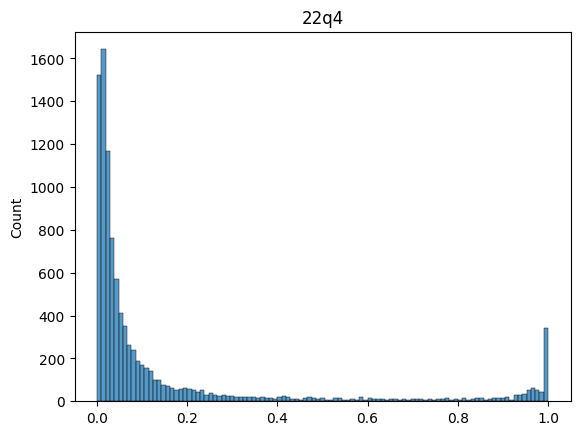

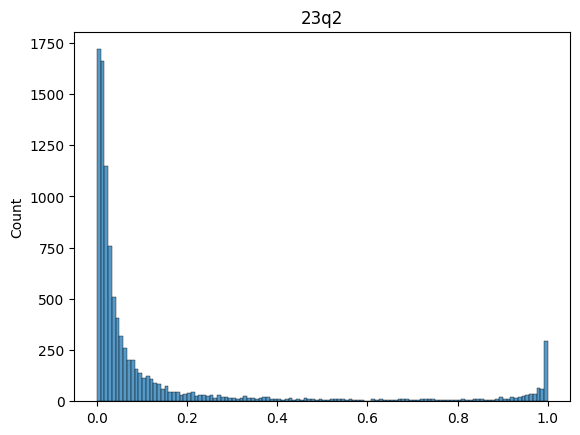

In [3]:
for dataset in ['22q4', '23q2']:
    plt.figure()
    plt.title(dataset)
    sns.histplot(np.random.choice(depmap_cleaned[dataset].values.flatten(), 10000));

### Center data

In [4]:
depmap_centered = {}
for dataset in ['22q4', '23q2']:
    depmap_centered[dataset] = depmap_cleaned[dataset].sub(depmap_cleaned[dataset].mean(axis=1), axis=0)

## Distribution of dependency scores after centering per gene.

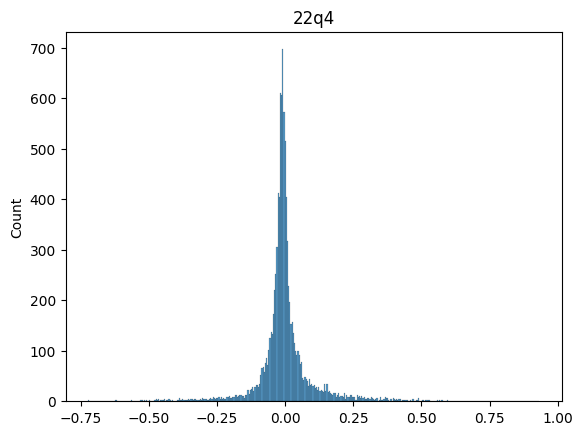

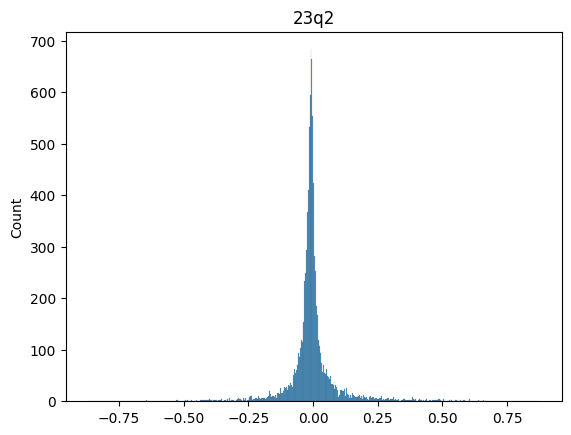

In [5]:
for dataset in ['22q4', '23q2']:
    plt.figure()
    plt.title(dataset)
    sns.histplot(np.random.choice(depmap_centered[dataset].values.flatten(), 10000));

# Add in chromosome positions
Drop genes without annotations

In [6]:
gene_dict, chrom_dict, band_dict = utils.chromosome_info.get_chromosome_info_as_dicts()
genes = list(gene_dict.keys())

depmap = {}
for dataset in ['22q4', '23q2']:

    # Subset to genes with chrom information from hg38
    idx = depmap_centered[dataset].query(f"gene.isin({genes})").index
    print(f'Full data has {depmap_centered[dataset].shape[0]} genes, {len(idx)} of which are in annotations')
    depmap[dataset] = depmap_centered[dataset].loc[idx]

    # Add in chromomsome information
    def _add_chr_info(df, gene_dict, in_nm, out_nm):
        df[out_nm] = depmap[dataset].index.to_frame().gene.apply(lambda x: gene_dict[x][in_nm] if x in gene_dict else "no_info")
        return df

    old_cols = depmap[dataset].columns.tolist()
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, 'chrom', 'chromosome')
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, 'chrom_int', 'chr_idx')
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, 'arm', 'chromosome_arm')
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, 'start', 'gene_bp')

    cols = ['gene', 'chromosome', 'chr_idx', 'chromosome_arm', 'gene_bp']
    depmap[dataset] = depmap[dataset].reset_index().set_index(cols).sort_values(['chr_idx', 'gene_bp'])

Full data has 17453 genes, 17396 of which are in annotations
Full data has 17202 genes, 17147 of which are in annotations


In [7]:
depmap['22q4'].head(2)

,,,,ModelID,ACH-000001,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,...,ACH-002672,ACH-002680,ACH-002687,ACH-002693,ACH-002710,ACH-002785,ACH-002800,ACH-002834,ACH-002847,ACH-002926
gene,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,,,,,,,,,,,,,,,,,
SAMD11,chr1,1,chr1p,923922,-0.044585,-0.042399,-0.016482,-0.047876,0.106571,-0.046186,-0.014407,-0.028470,-0.022098,-0.037385,...,0.023264,0.027425,0.001565,-0.033055,-0.023050,-0.026351,-0.039969,-0.029151,-0.034456,-0.029809
NOC2L,chr1,1,chr1p,944202,-0.413684,0.186547,-0.465314,0.192110,0.171907,-0.032978,0.202669,-0.051929,0.116841,-0.025716,...,0.191790,0.052890,-0.347379,0.016054,0.149912,0.088715,0.179232,-0.078525,0.170411,0.075313


In [8]:
depmap['23q2'].head(2)

,,,,ModelID,ACH-000001,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,...,ACH-002687,ACH-002693,ACH-002710,ACH-002785,ACH-002799,ACH-002800,ACH-002834,ACH-002847,ACH-002922,ACH-002926
gene,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,,,,,,,,,,,,,,,,,
SAMD11,chr1,1,chr1p,923922,-0.026304,-0.033231,0.009145,-0.043516,0.110019,-0.041632,-0.024825,-0.037381,-0.023137,-0.039153,...,-0.010375,-0.037649,-0.030746,-0.030628,-0.004704,-0.036681,-0.030431,-0.033419,-0.039891,-0.030880
NOC2L,chr1,1,chr1p,944202,-0.616919,0.174306,-0.402765,0.172815,0.123998,0.043032,0.168861,0.015425,0.115587,0.070701,...,-0.118170,-0.008956,0.123311,0.080660,-0.044955,0.132955,-0.131677,0.151582,0.053820,0.098501


# Make a split heatmap with the 22Q4 and 23Q2 data

Steps:
- Harmonize before pairwise (after cleaning). This drops genes not present in both datasets.
- Make pairwise matrices for each dataset
- Quantile normalize each dataset
- Make split matrix
- Plot

In [9]:
# Harmonize data
depmap2 = {}
intersect_genes = np.intersect1d(depmap['22q4'].index.get_level_values('gene'),
                                 depmap['23q2'].index.get_level_values('gene'))
depmap2['22q4'] = depmap['22q4'].query('gene in @intersect_genes')
depmap2['23q2'] = depmap['23q2'].query('gene in @intersect_genes')

In [ ]:
# This step can be slow - takes a ~10 minutes on my machine
depmap_mat = {}
depmap_mat_norm = {}
for dataset in ['22q4', '23q2']:
    depmap_mat[dataset] = make_pairwise_cos(depmap2[dataset])
    depmap_mat_norm[dataset] = q_norm(depmap_mat[dataset])

# Plot full genome split heatmap - 22Q4 above diagonal, 23Q2 below

In [ ]:
path = 'plots'
if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
depmap_22q4_23q2_split = make_split_cosmat(depmap_mat_norm['22q4'], depmap_mat_norm['23q2'])

In [ ]:
plot_heatmap(depmap_22q4_23q2_split, f_name=os.path.join(path, 'depmap_split.svg'), format='svg', 
            show_chr_lines = True, show_cent_lines = True, crunch_factor=10, title='')

## Zoom in on chromosome 1

In [ ]:
idx = depmap_22q4_23q2_split.query('chromosome=="chr1"').index
plot_heatmap(depmap_22q4_23q2_split.loc[idx, idx], f_name=os.path.join(path, 'depmap_split_chr1.svg'), format='svg', 
             show_chr_lines = True, show_cent_lines = True, crunch_factor=5, title='')

# Calculate BM stats

In [ ]:
# Setting sample fraction helps avoid memory issues
bm_all = {}
bm_arm = {}
for dataset in ['22q4', '23q2']:
    bm_all[dataset], bm_arm[dataset] = bm_metrics(depmap_mat_norm[dataset], verbose=False, sample_frac=0.1)

In [ ]:
tmp1 = bm_arm['22q4'].copy()
tmp1.index.name = 'Chromosome arm'
tmp1 = tmp1.assign(Condition = '22q4')
tmp1 = tmp1.reset_index().set_index(['Condition', 'Chromosome arm'])

tmp2 = bm_arm['23q2'].copy()
tmp2.index.name = 'Chromosome arm'
tmp2 = tmp2.assign(Condition = '23q2')
tmp2 = tmp2.reset_index().set_index(['Condition', 'Chromosome arm'])

arm_stats_df = pd.concat([tmp1, tmp2])

In [ ]:
tmp = arm_stats_df
tmp = tmp.reset_index().rename(columns={'prob':'P(intra-arm cosine > inter)'})
tmp = pd.concat([tmp.query('Condition=="22q4"'),
                 tmp.query('Condition=="23q2"')])
plot_bm_bar_pairs(tmp, x='Chromosome arm', y='P(intra-arm cosine > inter)', hue='Condition', 
                  lab1='22q4', lab2='23q2', i=1, legend_loc='upper left',
                  f_name=os.path.join(path, 'depmap_split_bars.svg'))